# Task

As a data analyst there is plenty of opportunity to improve processes or suggest new ways of doing things. When doing so it is often very smart and efficient (time is a scarce resource) to create a POC (Proof of Concept) which basically is a small demo checking wether it is worthwile going further with something. It is also something concrete which facilitates discussions, do not underestimate the power of that. 

In this example, you are working in a company that sells houses and they have a "manual" process of setting prices by humans. You as a Data Scientist can make this process better by using Machine Learning. Your task is to create a POC that you will present to your team colleagues and use as a source of discussion of wether or not you should continue with more detailed modelling. 

Two quotes to facilitate your reflection on the value of creating a PoC: 

"*Premature optimization is the root of all evil*". 

"*Fail fast*".

**More specifially, do the following:**

1. A short EDA (Exploratory Data Analysis) of the housing data set.
2. Drop the column "ocean_proximity", then you only have numeric columns which will simplify your analysis. Remember, this is a POC!
3. Split your data into train and test set. 
4. Create a pipeline containing a SimpleImputer [ SimpleImputer(strategy="median") ] and a std_scaler (and fit-transform your train set). 

5. Use GridSearchCV when choosing your model. You will look at a RandomForestRegressor with 2, 5, 10 or 100 estimators. More specifically, use the following code: 

```python
param_grid = [{'n_estimators': [2, 5, 10, 100]}]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(train_feature, train_label)
```

6. Evaluate your model on the test set using the mean squared error as the metric. Conclusions? (Remember, you have fitted your pipeline above so now you just transform your test set without fitting your pipeline on it, else it is "cheating".)

7. Do a short presentation (~ 2-5 min) on your POC that you present to your colleagues (no need to prepare anything particular, just talk from the code). Think of:
- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?


**(8. If you have time, try to build a better model than the one presented in the POC.)**

# POC

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


In [188]:
# Below, set your own path where you have stored the data file. 
housing = pd.read_csv(r'D:\Kurs 5 - Introduktion till maskininlarning\kunskapskontroll1\housing_data\housing.csv')

In [189]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 1. A short EDA (Exploratory Data Analysis) of the housing data set.

The dataset includes housing information in California State, USA.

Each observation (row) corresponds to a certain area inside California State.

In [190]:
# DataFrames column names
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Most of the column names are self explanatory:
- __longitude__: longitude coordinate of the area
- __latitude__: latitude coordinate of the area
- __housing_median_age__: median age of the houses in the area
- __total_rooms__: total amount of rooms  in the area
- __total_bedrooms__: total amount of bedrooms in the area
- __population__: population in the area
- __households__: number of households in the area
- __median_income__: median income in the area
- __median_house_value__: median house value in the area (__TARGET FEATURE__)
- __ocean_proximity__: proximity to the ocean from the area

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Most of our features are numeric, only ocean_proximity being "categorical" (but in our case it has a type object, which means the categories are strings, and not real category data type).

In [6]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Seems like we have missing values in the total_bedrooms feature. As there are not many values missing (~1%) from the feature, we could just simply drop these observations, but we will choose imputation instead. 

This step comes later after train-test split to avoid data leakage (test set being influenced by training set data).

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Based on the summary statistics, we can see that there is a large range between the min and max for all the features (if we dismiss coordinate data right now). It is interesting to look at the minimum and maximum values in the dataset just to have an indication.

Although it will come later, we can already think about what to impute to __total_bedrooms__. As the datapoints range is big with possible outliers, the median value would be possibly more suitable (to compansate the skweness in the data towards the extremes).

I could think about finding the missing observations, and imputing the missing total_bedroom data, based on the median value for similar sized areas...

In [8]:
housing.describe(include='object')

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [9]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

As for our 'categorical' data, we have 5 unique categories, and the most common is <1H OCEAN.

## Data visualization

### Distribution of data

array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'housing_median_age'}>],
       [<AxesSubplot: title={'center': 'total_rooms'}>,
        <AxesSubplot: title={'center': 'total_bedrooms'}>,
        <AxesSubplot: title={'center': 'population'}>],
       [<AxesSubplot: title={'center': 'households'}>,
        <AxesSubplot: title={'center': 'median_income'}>,
        <AxesSubplot: title={'center': 'median_house_value'}>]],
      dtype=object)

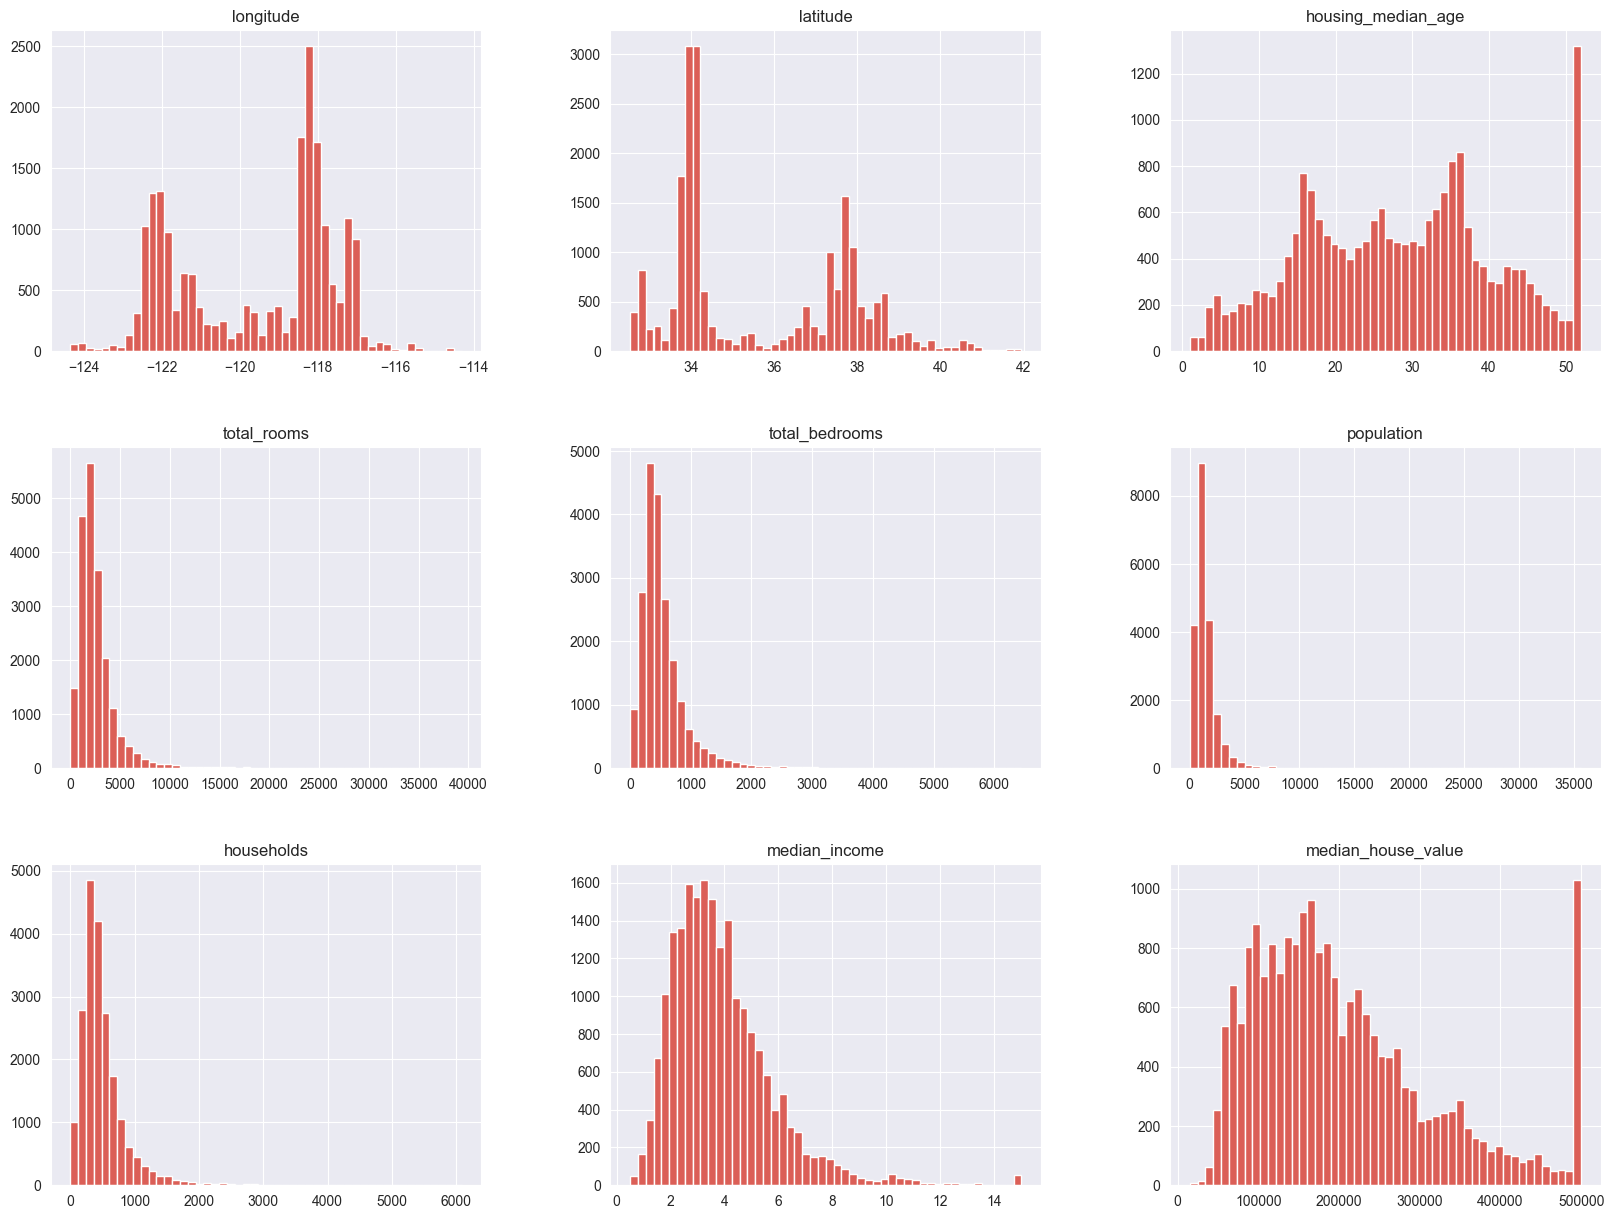

In [179]:
sns.set_style('darkgrid')
housing.hist(bins=50, figsize=(20,15))

__Other observations__ 
- the __median_income__ feature: it does not show a continous values of median income in dollars, but rather some kind of categories, with a lower limit of 0.499900 and upper limit of 15.000100. __Further investigations from the data provider is advised!__
- the __housing_median_age__ feature: seems like the median age of houses in an area has an upper limit as well at 52 years. __Further investigations from the data provider is advised!__
- the __median_house_value__ feature: seems like the median house value has in an area has an upper limit of 500.000 dollars. __Further investigations from the data provider is advised!__
- most of our features follows Poisson-distribution: a majority of the values are in the lower range, and a very small part of the values are above this majority. __Consider logarithmic transformation???__

## Correlation of features

In [182]:
housing.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049457
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Correlation of features visualized

<AxesSubplot: >

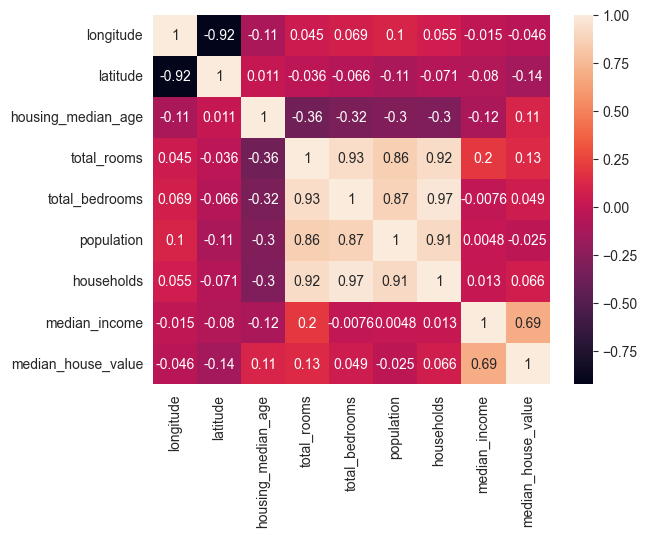

In [183]:
sns.heatmap(housing.corr(numeric_only=True), annot=True)

In [184]:
corr_vals = housing.corr(numeric_only=True)['median_house_value']
# selecting features with correlation > |0.1|
features_to_keep = corr_vals[((corr_vals>0.1)|(corr_vals<-0.1))]#&(corr_vals.keys()!='median_house_value')]

Only 4 features have a noticable (>|0.1|) correlation with the target feature. These features are:

In [185]:
features_to_keep

latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

## Further viaulaization of the most informatiove features

- The distribution of the features visualized on a bar plot
- The general connection between them visualized on a scatter plot

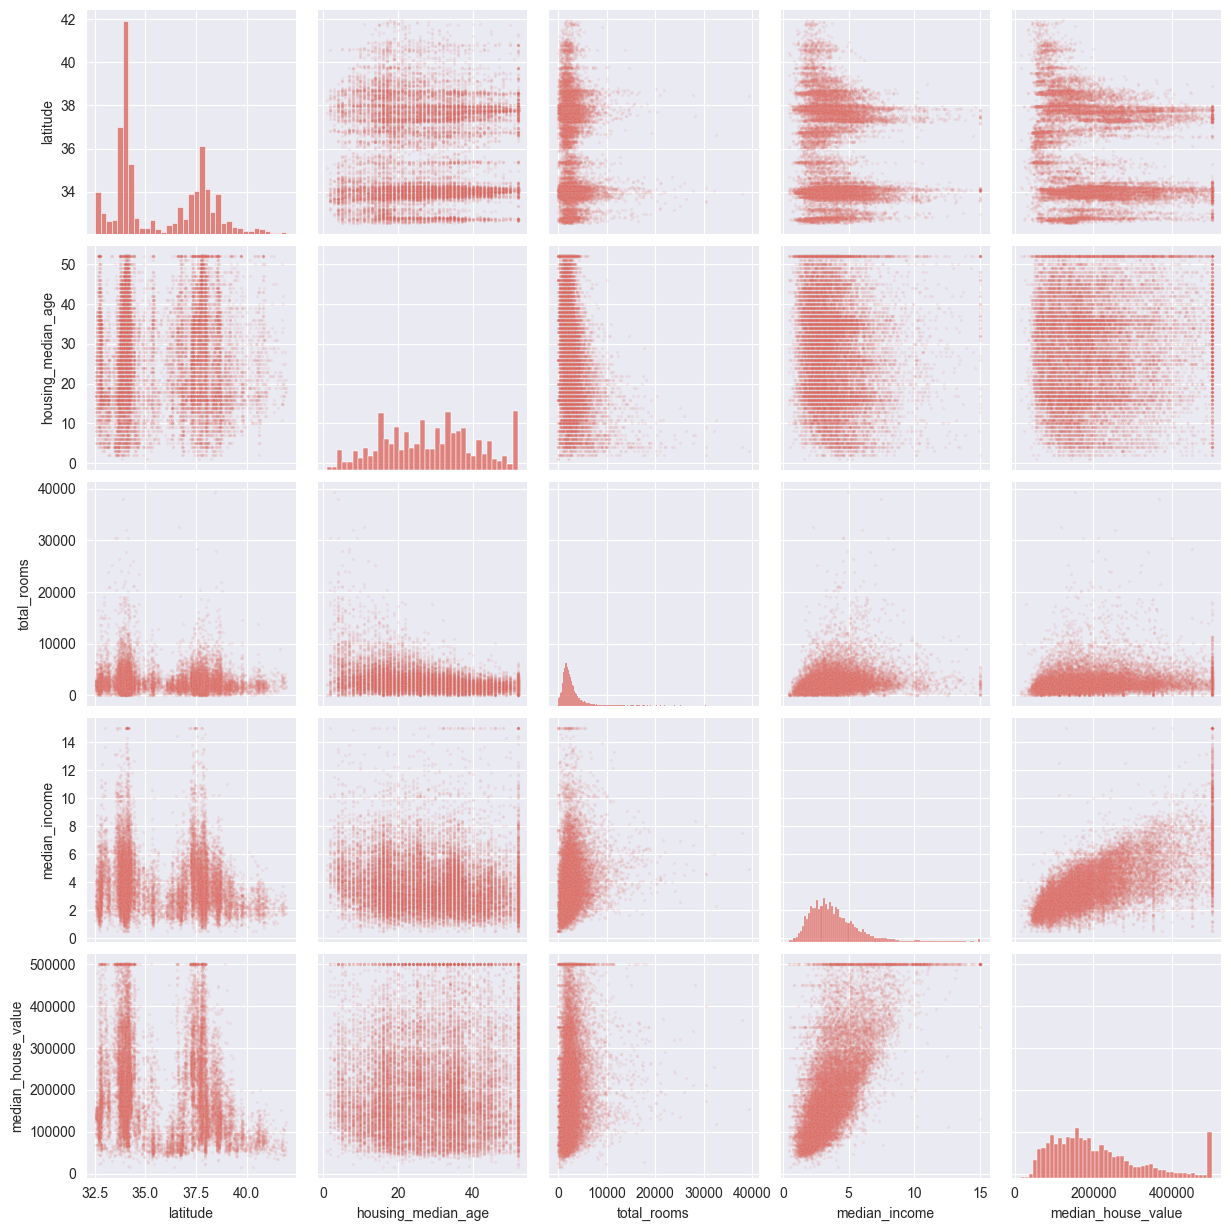

In [186]:
sns.pairplot(data=housing[features_to_keep.keys()], plot_kws=dict(s=5, edgecolors='b', alpha=0.1))

## Investigating visually if the missing data is systematically missing or not

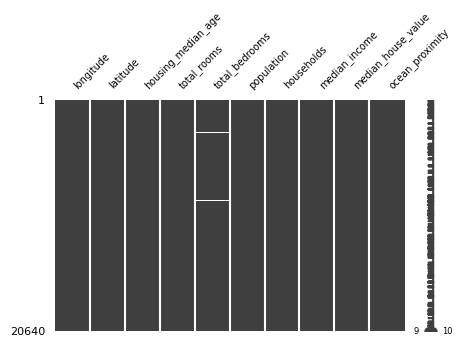

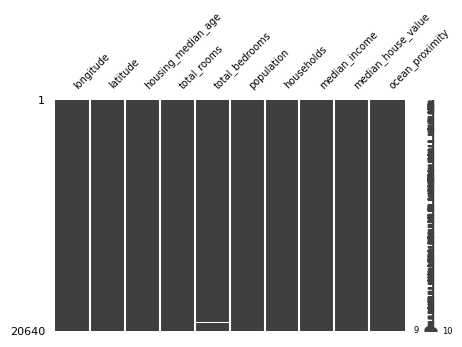

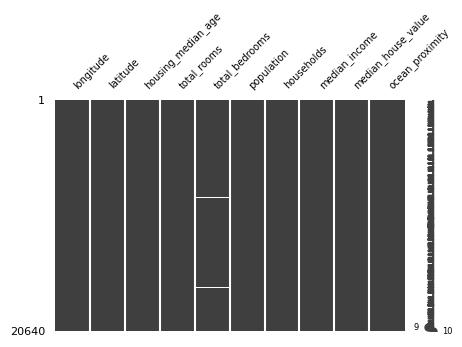

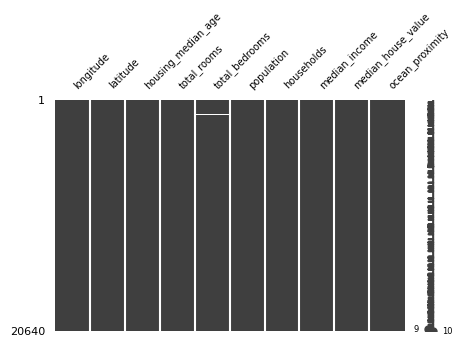

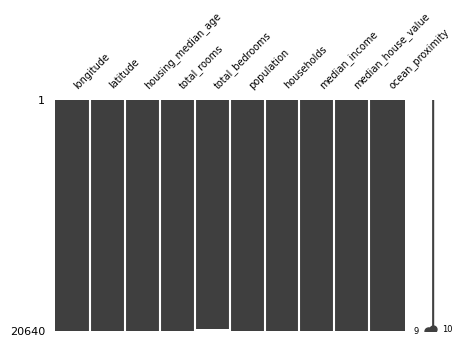

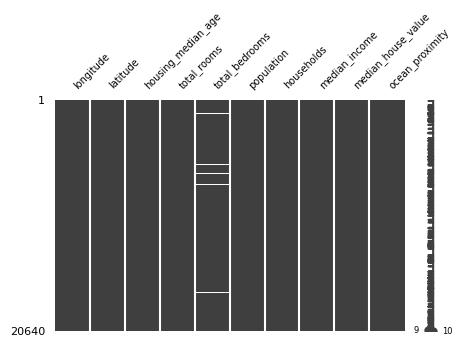

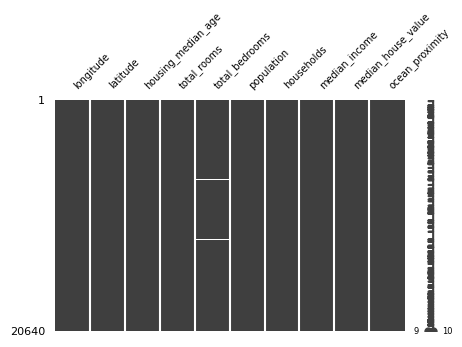

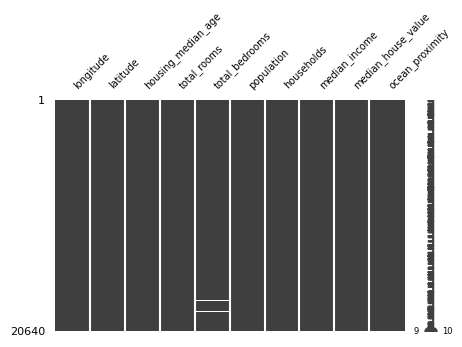

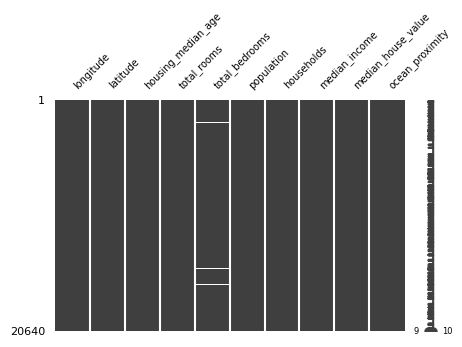

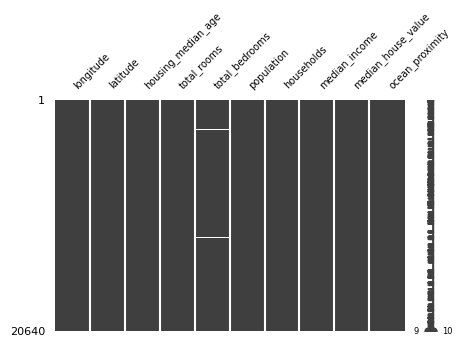

In [18]:
for c in housing.columns:
    msno.matrix(housing.sort_values(c), figsize=(5,3), fontsize=7)

__Observations__

It seems like that the missing values in total_bedrooms are Missing Completely At Random. 
As the visualizations show above there is no systematic structure or pattern that can explain the missing values (at least based on the provided features).

## 2. Drop the column "ocean_proximity", then you only have numeric columns which will simplify your analysis.

In [19]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [191]:
housing.drop('ocean_proximity', axis=1, inplace=True)

In [21]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

## 3. Split your data into train and test set.

In [22]:
train, test = train_test_split(housing, test_size=0.2, shuffle=True, random_state=42)

In [23]:
train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.582290,35.643149,28.608285,2642.004784,538.496851,1426.453004,499.986919,3.880754,207194.693738
std,2.005654,2.136665,12.602499,2174.646744,419.007096,1137.056380,380.967964,1.904294,115622.626448
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.810000,33.930000,18.000000,1454.000000,296.750000,789.000000,280.000000,2.566700,119800.000000
50%,-118.510000,34.260000,29.000000,2129.000000,437.000000,1167.000000,410.000000,3.545800,179850.000000
75%,-118.010000,37.720000,37.000000,3160.000000,647.000000,1726.000000,606.000000,4.773175,265125.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [24]:
test.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.00000,4128.00000,4128.000000,4128.000000,3921.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.51936,35.58671,28.764293,2610.796269,535.233104,1421.571705,497.750727,3.830338,205500.309593
std,1.99447,2.13276,12.518304,2209.359101,431.299704,1114.023136,387.770570,1.881515,114486.964288
min,-124.19000,32.54000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000
25%,-121.69000,33.93000,18.000000,1420.000000,294.000000,781.000000,278.000000,2.548500,119275.000000
50%,-118.47000,34.23000,29.000000,2110.000000,428.000000,1160.000000,406.000000,3.500000,178650.000000
75%,-117.99000,37.70000,37.000000,3099.250000,643.000000,1722.000000,598.000000,4.645925,263000.000000
max,-114.58000,41.81000,52.000000,37937.000000,5471.000000,16122.000000,5189.000000,15.000100,500001.000000


## 4.0 Separating target and predictors

In [82]:
X_train = train.drop('median_house_value', axis=1).values
y_train = train.median_house_value.values
X_test = test.drop('median_house_value', axis=1).values
y_test = test.median_house_value.values

## 4. Create a pipeline containing a SimpleImputer [ SimpleImputer(strategy="median") ] and a std_scaler (and fit-transform your train set).

In [87]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

pipe_steps = [
    ('imputer', imputer),
    ('scaler', scaler)
]

pipeline = Pipeline(pipe_steps)

train_transformed = pipeline.fit_transform(X_train)
# X_train = pd.DataFrame(train_transformed, columns=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms', 'population','households','median_income'])

## 5. Use GridSearchCV when choosing your model. You will look at a RandomForestRegressor with 2, 5, 10 or 100 estimators.

In [382]:
from sklearn.metrics import get_scorer_names
# get_scorer_names()

In [28]:
hyper_grid = [
    {'n_estimators':[2,5,10,100]}
]

rfr = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(rfr, hyper_grid, cv=kf, scoring='neg_mean_squared_error', return_train_score=True, refit=True)

grid_search.fit(train_transformed, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'n_estimators': [2, 5, 10, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [99]:
grid_search.best_params_

{'n_estimators': 100}

In [30]:
grid_search.best_estimator_

RandomForestRegressor(random_state=42)

In [31]:
best_train_cv_score = np.sqrt(-grid_search.best_score_)
best_train_cv_score

50143.22583885239

In [110]:
# RMSE in ratio of mean training price
best_train_cv_score/y_train.mean()

0.2420101834378358

## 6. Evaluate your model on the test set using the mean squared error as the metric. Conclusions? (Remember, you have fitted your pipeline above so now you just transform your test set without fitting your pipeline on it, else it is "cheating".)

In [32]:
test_transformed = pipeline.transform(X_test)
final_model = grid_search.best_estimator_
y_pred = final_model.predict(test_transformed)

In [33]:
final_rmse_score = mean_squared_error(y_test, y_pred, squared=False)
final_rmse_score

49875.648686594046

In [109]:
# RMSE in ratio of mean test price
final_rmse_score/y_test.mean()

0.24270352091132483

## 6.1 Conclusions

In [34]:
pd.DataFrame(data=[best_train_cv_score, final_rmse_score], index=['Training score','Test score'], columns=['RMSE score'])

,RMSE score
Training score,50143.225839
Test score,49875.648687


As we can see the training score is within a reasonable error range, and our test score is even slightly better.
For a first look it seems like that our model does generalize well enough when new, unseen data is presented to it.

Even though the model performed well on previously unseen data improvements can always be made.
Here are some recommendations:
- Get more data to train on
- Improve the quality of our overall data, especially the training data
- Create/modify features which might give valuable insights and correlate better with the target feature
- More exhaustive model selection and hyperparameter tuning

## 7. Do a short presentation (~ 2-5 min) on your POC that you present to your technical colleagues (no need to prepare anything particular, just talk from the code). Think of:

   __What do you want to highlight/present?__
   
 The company decided to see if using a machine learning model would be a viable option to estimate housing prices in the districts in California. 
 A viable model would be used to aid the real estate agents in the approximate evaluation of housing prices.
 In the following presentation is a Proof of Concept for a machine learning model aiming to fulfill the above mentioned task.
 
 The data used for this POC was all numeic and with a very small amount of missing values, which were filled (with the median) down the pipeline. The missing data is missing completely on random. 
 
 According to the data, the best features to indicate the districts house prices are, the 
 - median_income, 
 - total_rooms, 
 - housing_median_age and the 
 - latitude 
 of the district. These features have the strongest correlation to the median_house_value target feature.
 
The RandomForestRegressor model gave an RMSE of ~50.000 dollars, roughly 24% error from the actual median prices in the districts.
 
   __What is your conclusion?__
   
The conclusion is that this POC model can effectively predict the median house value in a California district with around ~25% error margin compared to the real median house value in a district. Further efforts into making a more precise model could be deemed viable based on the project owners performance goals and decisions.
    
   __What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?__
   
The POC shows a promising result, meaning that the initial model could consistently predict values within a 25% error margin from the real values. This kind of prediction model can save time for the estate agents, and dial in their preliminary house value estimations.

This POC model is not ready yet for production; further improvements are highly recommended.

Being a POC, the both the data and the model can be improved. Here are the recommendations for improvement:

- Get more data to train on
- Improve the quality of our overall data: the framework of what kind of data and how it is collected could be more closely coordinated between the data collection and data science teams.
- Create/modify features which might give valuable insights and correlate better with the target feature
- More exhaustive model selection and hyperparameter tuning


## 8. If you have time, try to build a better model than the one presented in the POC.

### 8.1 feature engineering experiments

<AxesSubplot: >

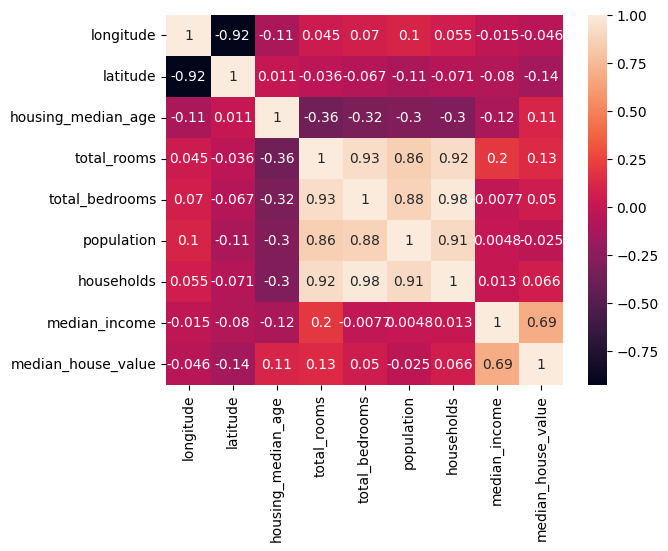

In [35]:
sns.heatmap(housing.corr(numeric_only=True), annot=True)

Looking again at the correlation heatmap.
It might be beneficial to combine the features which have a high correlation.
We will check their combined correlation with the target feature below.

In [192]:
# combination of all features divided with eachother, and their correlation to the target value
dic = {}
for c in housing.columns:
    feat_to_check = housing.columns
    feat_dict = {c:[]}
    for f in feat_to_check:
        corr_val = (housing[f]/housing[c]).corr(housing.median_house_value)
        feat_dict[c].append(corr_val)
    dic.update(feat_dict)
    
dat = pd.DataFrame(index= housing.columns, columns=housing.columns, data=dic)

# correlatons higher than |0.1|
possible_combos_df = dat.where(~((dat<0.1)&(dat>-0.1))).iloc[0:-1,0:-1]
possible_combos_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,NaN,-0.202722,NaN,NaN,NaN,NaN,NaN,0.517998
latitude,0.209051,NaN,NaN,NaN,NaN,NaN,NaN,-0.526447
housing_median_age,-0.103447,0.119728,NaN,NaN,NaN,NaN,NaN,-0.320028
total_rooms,-0.132416,0.141450,NaN,NaN,0.38392,0.209482,0.151948,-0.209103
total_bedrooms,NaN,NaN,NaN,-0.255880,NaN,NaN,NaN,-0.225681
population,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.280478
households,NaN,NaN,NaN,-0.214654,NaN,0.264910,NaN,-0.218872
median_income,-0.685794,0.689831,0.207899,NaN,NaN,0.114455,NaN,NaN


In [193]:
# choosing the feature combinations with the highest correlation between the features themselves.
# The values in the dataframe are the features divided with eachother, and their correlation to the target value.
dat.iloc[3:-2,3:-2]

,total_rooms,total_bedrooms,population,households
total_rooms,NaN,0.383920,0.209482,0.151948
total_bedrooms,-0.255880,NaN,0.069896,-0.046739
population,-0.033557,-0.019179,NaN,-0.023737
households,-0.214654,0.091680,0.264910,NaN


In [194]:
# correlations higher than |0.1| based on the heatmap correlations
possible_combos_from_heatmap = dat.where(~((dat<0.1)&(dat>-0.1))).iloc[3:-2,3:-2]
possible_combos_from_heatmap

,total_rooms,total_bedrooms,population,households
total_rooms,NaN,0.38392,0.209482,0.151948
total_bedrooms,-0.255880,NaN,NaN,NaN
population,NaN,NaN,NaN,NaN
households,-0.214654,NaN,0.264910,NaN


In [195]:
# features and all their combinations in a dictionary
possible_combos = (possible_combos_from_heatmap.stack().reset_index(level=1).groupby(level=0, sort=False)['level_1'].apply(list)).to_dict()
print('Dicionary of combinations:\n', possible_combos, end='\n\n')

# features and all their combinations in a list
possible_combos_list = []
for k in possible_combos:
    for v in possible_combos[k]:
        possible_combos_list.append([k,v])
print('List of all possible combinations:\n', possible_combos_list)

Dicionary of combinations:
 {'total_rooms': ['total_bedrooms', 'population', 'households'], 'total_bedrooms': ['total_rooms'], 'households': ['total_rooms', 'population']}

List of all possible combinations:
 [['total_rooms', 'total_bedrooms'], ['total_rooms', 'population'], ['total_rooms', 'households'], ['total_bedrooms', 'total_rooms'], ['households', 'total_rooms'], ['households', 'population']]


### In order to calculate the slopes we need to fill the Nan values in total_bedrooms

In [196]:
housing[['total_rooms','total_bedrooms']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_rooms     20640 non-null  float64
 1   total_bedrooms  20433 non-null  float64
dtypes: float64(2)
memory usage: 322.6 KB


In [197]:
imputer = SimpleImputer(strategy='median')
housing_cols = housing.columns
housing = imputer.fit_transform(housing)
housing = pd.DataFrame(housing, columns=housing_cols)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Correlations between the newly constructed feature combinations and median_house_value visualized

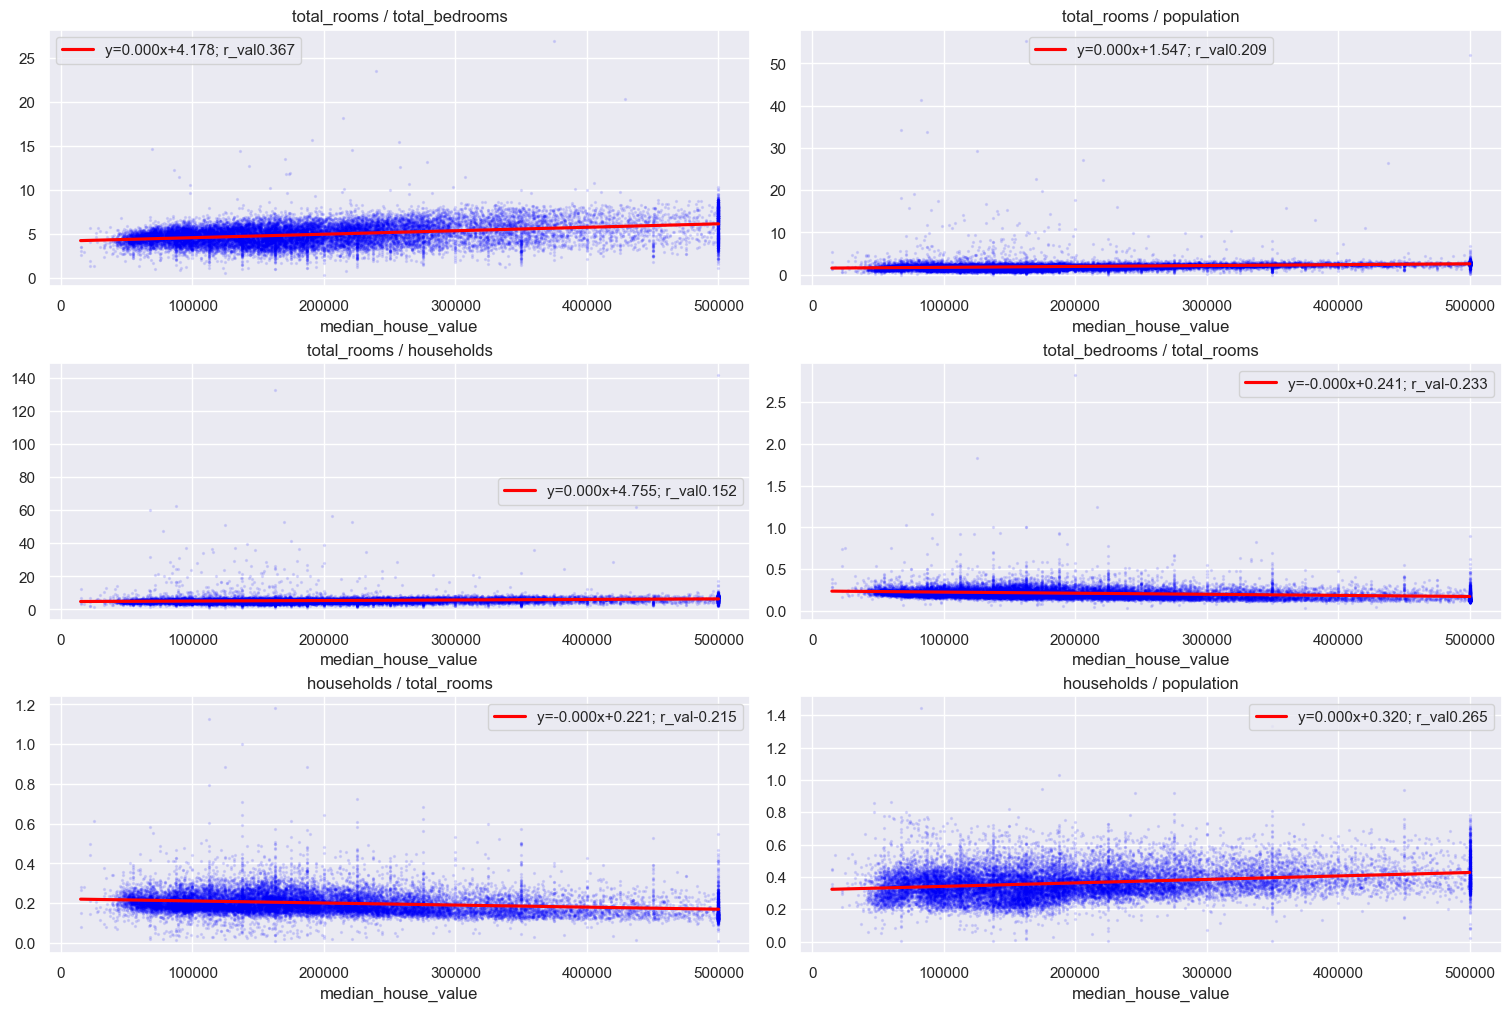

In [303]:
from scipy.stats import linregress
sns.set_theme()
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,10), layout='constrained')

for i,ax in enumerate(axs.flatten()):
    slope, intercept, r_value, p_value, std_err = linregress(housing.median_house_value, housing[possible_combos_list[i][0]]/housing[possible_combos_list[i][1]])
    sns.regplot(ax=ax, x=housing.median_house_value, y=housing[possible_combos_list[i][0]]/housing[possible_combos_list[i][1]], scatter_kws={"color": "blue", 'alpha':0.1, 's':2}, line_kws={"color": "red", 'label':"y={0:.3f}x+{1:.3f}; r_val{2:.3f}".format(slope,intercept, r_value)})
    ax.legend()
    ax.title.set_text(possible_combos_list[i][0]+' / '+possible_combos_list[i][1])
plt.show()

### Observation:
There are concentrations of median house values around: 80k, 120k, 140k, 160k, 180k, 225k, 250k, 275k, 325k, 350k, 375k, 450k

## Visualizing the same feature combinations and their relation to the target feature, but now with changed axis

Why?

The range of median_house_value is from ~15000 to ~500000. When this feature is on the x-axis, one change in the unit will result in a miniscule change on the y-axis value, which range everything from 0 to 1.4 and 0 to 140.

By changing up the axes, we can observe a more markant change in y-axis values when one unit of x-axis value is changed.
It is simply a visually stronger representation of the correlations.

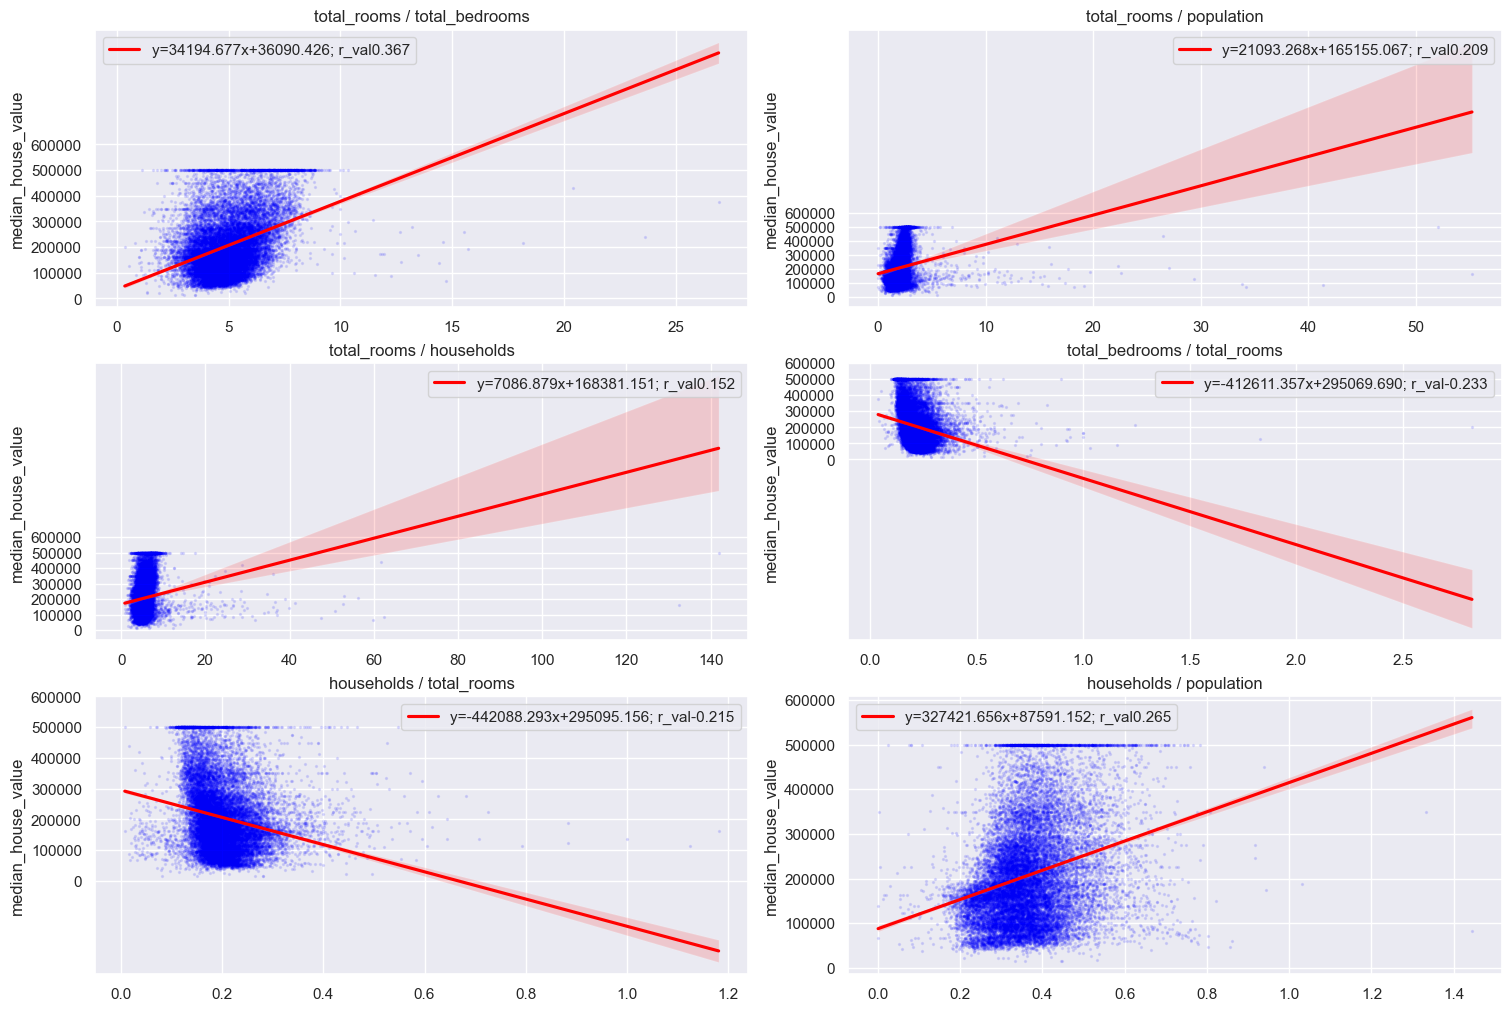

In [414]:
from scipy.stats import linregress
sns.set_theme()
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,10), layout='constrained')

for i,ax in enumerate(axs.flatten()):
    slope, intercept, r_value, p_value, std_err = linregress(housing[possible_combos_list[i][0]]/housing[possible_combos_list[i][1]], housing.median_house_value)
    sns.regplot(ax=ax, y=housing.median_house_value, x=housing[possible_combos_list[i][0]]/housing[possible_combos_list[i][1]], scatter_kws={"color": "blue", 'alpha':0.1, 's':2}, line_kws={"color": "red", 'label':"y={0:.3f}x+{1:.3f}; r_val{2:.3f}".format(slope,intercept, r_value)})
    ax.legend()
    ax.set_yticks([0,100000,200000,300000,400000,500000,600000])
    ax.title.set_text(possible_combos_list[i][0]+' / '+possible_combos_list[i][1])
plt.show()

__Observation__

Although there is a sense of correlation in all of the feature combinations against the median_house_value, the plots show that there is no real/extremely strong linear correlation between them, more like a hint of a general tendency. 

There are also many outliers, which have a big (distorting) effect on the ordinary least squares line, and thus possibly the whole model, if these features are used.

### 8.1 Creating a train, validation and test set

In [198]:
train_set, test_set = train_test_split(housing, test_size=0.2, shuffle=True, random_state=42)

In [199]:
train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=42)

In [200]:
sets = [train_set, test_set, validation_set]
for set in sets:
    print(set.shape)

(13209, 9)
(4128, 9)
(3303, 9)


In [201]:
assert len(housing) == len(train_set)+len(validation_set)+len(test_set)

In [225]:
X_train = train_set.drop('median_house_value', axis=1)
y_train = train_set.median_house_value
X_val = validation_set.drop('median_house_value', axis=1)
y_val = validation_set.median_house_value
X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set.median_house_value

In [226]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
16490,-120.97,38.00,27.0,1683.0,288.0,873.0,258.0,4.7069
6090,-117.87,34.10,15.0,6409.0,1363.0,3359.0,1267.0,3.8750
10973,-117.85,33.76,26.0,2312.0,525.0,1273.0,437.0,2.8828
17287,-119.74,34.35,34.0,1664.0,292.0,705.0,257.0,5.0000
12615,-121.51,38.50,25.0,4719.0,745.0,1857.0,739.0,5.0371


In [227]:
X_val.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
2071,-119.85,36.74,35.0,1191.0,190.0,537.0,182.0,3.5375
2612,-124.16,41.02,23.0,1672.0,385.0,1060.0,390.0,2.1726
10838,-117.92,33.67,14.0,6224.0,1679.0,3148.0,1589.0,4.2071
4061,-118.45,34.15,10.0,1091.0,260.0,517.0,266.0,4.1727
10767,-117.90,33.63,28.0,2370.0,352.0,832.0,347.0,7.1148


### Create extra feature creator

In [203]:
possible_combos_list

[['total_rooms', 'total_bedrooms'],
 ['total_rooms', 'population'],
 ['total_rooms', 'households'],
 ['total_bedrooms', 'total_rooms'],
 ['households', 'total_rooms'],
 ['households', 'population']]

There are duplicates in this list, so we take out some of them instead, based on what makes sense:
- ['total_rooms', 'total_bedrooms']: bedrooms are a subset of rooms, so bedrooms/rooms would be more logical __discard__
- ['total_rooms', 'population']: rooms per population might be useful: how many rooms does a person "get" on average? __keep__
- ['total_rooms', 'households']: rooms per household might be useful: how many rooms are in a household on average? __keep__
- ['total_bedrooms', 'total_rooms']: bedrooms per rooms might be useful: what percentage of the rooms are bedrooms? __keep__
- ['households', 'total_rooms']: household and rooms combination already exists, and rooms/household sounds more logical __discard__
- ['households', 'population']: household per population might be useful: how many households are there per individual? __keep__

In [204]:
possible_combos_list.pop(0)
possible_combos_list.pop(3)
possible_combos_list

[['total_rooms', 'population'],
 ['total_rooms', 'households'],
 ['total_bedrooms', 'total_rooms'],
 ['households', 'population']]

<AxesSubplot: >

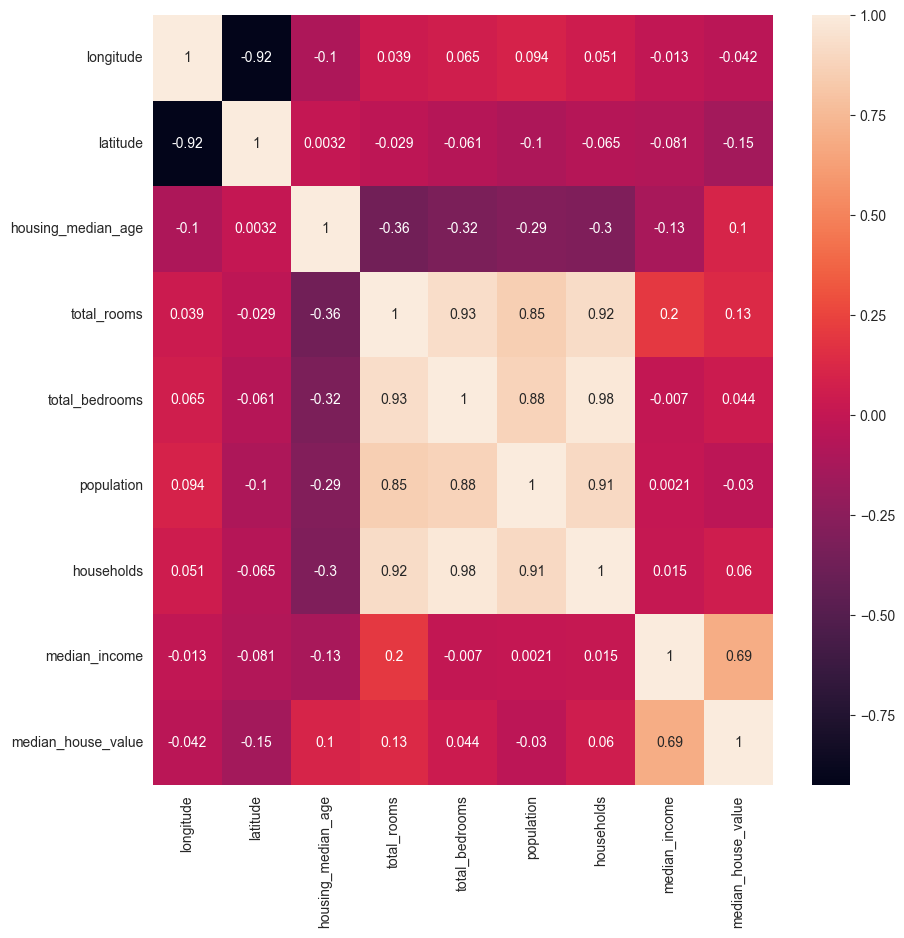

In [205]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(), annot=True)

__Observation__

The new features seem to correlate with median_house_value more than most of the other original features.

## Custom transformer for creting the new features

In [228]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    train_set.columns.get_loc(c) for c in col_names] # get the column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_population = X[:, rooms_ix] / X[:, population_ix]
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        household_per_population = X[:, households_ix] / X[:, population_ix]        
        return np.c_[X, rooms_per_population, rooms_per_household, bedrooms_per_room, household_per_population]

attr_adder = CombinedAttributesAdder()

In [229]:
df_columns = list(X_train.columns) + ['rooms_per_population', 'rooms_per_household', 'bedrooms_per_room', 'household_per_population']
df_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_population',
 'rooms_per_household',
 'bedrooms_per_room',
 'household_per_population']

## Pipeline transformation of data

In [230]:
pipe_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('feature_adder', CombinedAttributesAdder())
    
]

pipe = Pipeline(pipe_steps)

__Note to future me: Train dataset is fitted and transformed and the validation and test dataset is ONLY transformed right??? It worths to double check this! ;)__

In [231]:
X_train= pd.DataFrame(data=pipe.fit_transform(X_train), columns=df_columns, index=X_train.index)
X_val= pd.DataFrame(data=pipe.transform(X_val), columns=df_columns, index=X_val.index)
X_test= pd.DataFrame(data=pipe.transform(X_test), columns=df_columns, index=X_test.index)

In [232]:
print(X_train.shape, X_val.shape, X_test.shape)

(13209, 12) (3303, 12) (4128, 12)


In [233]:
print(type(X_train), type(X_val), type(X_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [236]:
X_val

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_population,rooms_per_household,bedrooms_per_room,household_per_population
2071,-0.133003,0.512312,0.510981,-0.672577,-0.839940,-0.782571,-0.843325,-0.175378,0.859446,0.797530,1.248837,1.077635
2612,-2.282427,2.518158,-0.442233,-0.448731,-0.368267,-0.322657,-0.290158,-0.897615,1.390735,1.546504,0.820686,0.899277
10838,0.829499,-0.926461,-1.157143,1.669664,2.761701,1.513479,2.898531,0.178941,1.103196,0.576038,1.654045,1.915145
4061,0.565185,-0.701506,-1.474881,-0.719115,-0.670621,-0.800158,-0.619931,0.160738,0.898716,1.159992,0.932565,0.774760
10767,0.839474,-0.945207,-0.045060,-0.123898,-0.448089,-0.523155,-0.404515,1.717549,0.236828,0.306288,3.616596,0.773222
...,...,...,...,...,...,...,...,...,...,...,...,...
18945,-1.220183,1.234042,-1.077709,1.153096,0.715369,0.871535,0.741711,0.327685,1.323064,1.554643,0.620390,0.851040
6011,0.904305,-0.743685,-0.124495,-0.213250,0.221927,0.837239,0.244393,-1.001328,-0.254707,-0.872573,-1.040690,0.291903
10502,0.939215,-1.020192,-0.601102,-0.199289,-0.007862,-0.003444,-0.045488,-0.146804,57.864366,4.381113,0.039448,13.207687
14688,1.248413,-1.334191,-0.283364,0.152071,0.035677,-0.232961,0.151312,-0.129077,-0.652772,1.005016,0.234611,-0.649515


## Model creation

### RandomForestRegressor with more hyperparameter testing

In [237]:
hyper_grid = [
    {'n_estimators':[200]},
    {'min_samples_split': [2,4,8]},
    {'min_samples_leaf': [1,2,4]}
]

rfr = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(rfr, hyper_grid, cv=kf, scoring='neg_mean_squared_error', return_train_score=True, refit=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'n_estimators': [200]},
                         {'min_samples_split': [2, 4, 8]},
                         {'min_samples_leaf': [1, 2, 4]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [238]:
grid_search.best_estimator_

RandomForestRegressor(min_samples_leaf=2, random_state=42)

In [239]:
grid_search.best_params_

{'min_samples_leaf': 2}

In [240]:
np.sqrt(-grid_search.best_score_)

50979.384913738744

### Training data cross-validation RMSE score

In [241]:
cv_score2 = np.sqrt(-cross_val_score(rfr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean())
# np.sqrt(-cv_score2.mean())
cv_score2

51231.935376642

### Validation data  RMSE score

In [242]:
best_model = grid_search.best_estimator_
y_pred2 = best_model.predict(X_val)
pred2_score = mean_squared_error(y_val, y_pred2, squared=False)
pred2_score

51464.58580960818

### HistGradientBoostingRegressor model
Based on results from auto-sklearn automated model testing on google colab. The auto-sklearn search best result was a 0.42-0.58 weighted combination of the HistGradientBoostingRegressor model. 

When trying to recreate the same model combination with VotingRegressor, i got worse results than using a simple HistGradientBoostingRegressor model. The hyperparameters are taken from the auto-sklearn search directly.

In [243]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [244]:
hgbr = HistGradientBoostingRegressor(l2_regularization=2.208787572338781e-05,
                                learning_rate=0.036087332404571744, max_iter=512,
                                max_leaf_nodes=64, min_samples_leaf=3,
                                n_iter_no_change=18, random_state=1,
                                validation_fraction=None, warm_start=True)
hgbr.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=2.208787572338781e-05,
                              learning_rate=0.036087332404571744, max_iter=512,
                              max_leaf_nodes=64, min_samples_leaf=3,
                              n_iter_no_change=18, random_state=1,
                              validation_fraction=None, warm_start=True)

### Training data cross-validation RMSE score

In [245]:
cv_score3 = np.sqrt(-cross_val_score(hgbr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean())
cv_score3

47408.08207797459

### Validation data RMSE score

In [246]:
y_pred3 = hgbr.predict(X_val)
pred3_score = mean_squared_error(y_val, y_pred3, squared=False)
pred3_score

47912.49437698566

## Gridsearch HistGradientBoostingRegressor

In [247]:
hyper_grid = [
    {'learning_rate':[0.01,0.02,0.03,0.04]},
    {'max_iter': [128,256,512,1024]},
    {'max_leaf_nodes': [64,128,256]},
    {'min_samples_leaf': [2,4,8]},
    {'n_iter_no_change': [10,20,30,50]}
]

hgbr2 = HistGradientBoostingRegressor(random_state=42)
kf2 = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search2 = GridSearchCV(hgbr2, hyper_grid, cv=kf2, scoring='neg_mean_squared_error', return_train_score=True, refit=True)

grid_search2.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=HistGradientBoostingRegressor(random_state=42),
             param_grid=[{'learning_rate': [0.01, 0.02, 0.03, 0.04]},
                         {'max_iter': [128, 256, 512, 1024]},
                         {'max_leaf_nodes': [64, 128, 256]},
                         {'min_samples_leaf': [2, 4, 8]},
                         {'n_iter_no_change': [10, 20, 30, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [248]:
np.sqrt(-grid_search2.best_score_)

47322.4728301995

In [249]:
grid_search2.best_estimator_

HistGradientBoostingRegressor(max_iter=256, random_state=42)

In [250]:
grid_search2.best_params_

{'max_iter': 256}

### Training data cross-validation RMSE score

In [251]:
cv_score4 = np.sqrt(-cross_val_score(grid_search2.best_estimator_, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean())
cv_score4

47374.709251809225

### Validation data RMSE score

In [252]:
y_pred4 = grid_search2.best_estimator_.predict(X_val)
y_pred4_score = mean_squared_error(y_val, y_pred4, squared=False)
y_pred4_score

48972.40858276975

## Results

In [253]:
pd.DataFrame(data= [(cv_score2, pred2_score), (cv_score3, pred3_score), (cv_score4, y_pred4_score)], columns=['Cross_val_scores', 'RMSE'], index=['RandomForestRegressor', 'HistGradientBoostingRegressor', 'HistGradientBoostingRegressorGS']).sort_values('RMSE')

,Cross_val_scores,RMSE
HistGradientBoostingRegressor,47408.082078,47912.494377
HistGradientBoostingRegressorGS,47374.709252,48972.408583
RandomForestRegressor,51231.935377,51464.585810


## Final model

In [254]:
hgbr.fit(X_train, y_train)
y_pred5 = hgbr.predict(X_test)
pred5_score = mean_squared_error(y_test, y_pred5, squared=False)
pred5_score

46196.48200357258

In [255]:
# RMSE in ratio of mean test price
pred5_score/y_test.mean()

0.2248000603749015

# Conclusion

While the idea of constructing more features from ones which have a high correlation does seem like a reasonable idea which can benefit the models performance, it seems like that the new models are all overfitted, which is most likely because of the new features.

Further steps would be to:
- get more training data
- experiment with different combination of features fitted to the model
- try out new models

__WELL...NOT REALLY__

This line was added after a thorough and exhausting troubleshooting. What went wrong? Well someone forgot to change the .fit_transform() function call from the training dataset, to __ONLY__ .transform() for the validation and test dataset.
Wonderful, besides learning a lot from big, medium and small mistakes, it looks like that the models actually benefited from the feature engineering done in this section.

We could improve from the initial RadnomForestRegressor models 49875.6 USD RMSE, to HistGradientBoostingRegressor models 46196.4 USD RMSE, from a 24.2% error from the average median_house_value to 22.4% error.